In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from math import sqrt
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
%matplotlib inline
np.random.seed(1337)


#Import Training Dataset
trainds = pd.read_csv('train.csv', engine='python')
# trainds = trainds[trainds.Interpoliert != 1]
trainds = trainds.loc[:, trainds.columns != 'Interpoliert']
data = trainds.loc[:, trainds.columns != 'Datum']

dataset = data.values
# #Import Challenge(test) Dataset
chall = pd.read_csv('challenge.csv', engine='python')
chall = chall.loc[:, chall.columns != 'Interpoliert']
chall = chall.loc[:, chall.columns != 'Datum']
dchall = chall.replace(to_replace= 'X', value=0)
# combine train and challenge df's
frames=[data,dchall]
fulldf = pd.concat(frames)
fulldf = fulldf.values
data.shape, dchall.shape



/home/kmillanr/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


((52508, 17), (17668, 17))

In [2]:
## TRAIN DATA
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(dataset)

## FULL CHALLENGE AND TRAIN DF
Cscaled = scaler.fit_transform(fulldf)
Cscaled.shape

(70176, 17)

In [3]:
# split TRAIN DATA into train and test sets
values = np.array(Cscaled, dtype=np.float32)
n_train = int(len(fulldf) * 0.3)
train = values[:n_train, :]
test = values[n_train:, :]

# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]


In [4]:
# reshape input to be 3D [samples, steps, features]
train_X = train_X.reshape((train_X.shape[0], 1, 16))
test_X = test_X.reshape((test_X.shape[0], 1, 16))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(21052, 1, 16) (21052,) (49124, 1, 16) (49124,)


In [481]:
from keras import regularizers

# create and fit the LSTM network
model = Sequential()
# for i in range(2):
model.add(LSTM(100, input_shape=(1,16),
            dropout = 0.1, activation = 'relu', 
            kernel_regularizer=regularizers.l2(0.06)))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adamax')
history= model.fit(train_X, train_y, epochs=30,validation_data=(test_X, test_y), batch_size=2048, shuffle=False)
model.summary()

Train on 21052 samples, validate on 49124 samples
Epoch 1/30
21052/21052 [==============================] - 59s 3ms/step - loss: 1.7259 - val_loss: 1.2171
Epoch 2/30
21052/21052 [==============================] - 2s 87us/step - loss: 1.0617 - val_loss: 0.7869
Epoch 3/30
21052/21052 [==============================] - 2s 89us/step - loss: 0.6883 - val_loss: 0.5346
Epoch 4/30
21052/21052 [==============================] - 2s 88us/step - loss: 0.4728 - val_loss: 0.3842
Epoch 5/30
21052/21052 [==============================] - 2s 87us/step - loss: 0.3487 - val_loss: 0.2942
Epoch 6/30
21052/21052 [==============================] - 2s 89us/step - loss: 0.2764 - val_loss: 0.2422
Epoch 7/30
21052/21052 [==============================] - 2s 87us/step - loss: 0.2334 - val_loss: 0.2122
Epoch 8/30
21052/21052 [==============================] - 2s 87us/step - loss: 0.2066 - val_loss: 0.1941
Epoch 9/30
21052/21052 [==============================] - 2s 87us/step - loss: 0.1892 - val_loss: 0.1820
Epoch

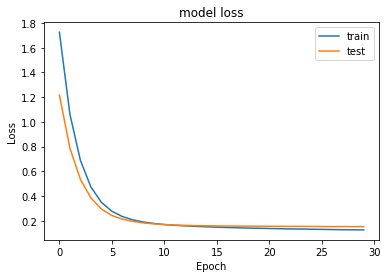

In [482]:
#plot learning curve
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.title('model loss')
plt.ylabel('Loss')

plt.xlabel('Epoch')
plt.legend()

plt.show()


In [483]:
# make predicdata:
trainPredict = model.predict(train_X)
testPredict = model.predict(test_X)
print(trainPredict.shape, testPredict.shape)
# Get something which has as many features as dataset
trainPredict_extended = np.zeros((len(trainPredict),16))
# Put the predictions there
trainPredict_extended = np.hstack((trainPredict_extended, trainPredict))
# print(trainPredict_extended.shape)
# # Inverse transform it and select the last column.
trainPredict = scaler.inverse_transform(trainPredict_extended) [:,-1]
# Get something which has as many features as dataset
testPredict_extended = np.zeros((len(testPredict),16))
# print(testPredict_extended.shape)
# Put the predictions there
testPredict_extended = np.hstack((testPredict_extended, testPredict))
# print(testPredict_extended.shape)
# Inverse transform it and select the last column.
testPredict = scaler.inverse_transform(testPredict_extended) [:,-1]
print(testPredict.shape, testPredict)
testdf= pd.DataFrame(testPredict)
# testdf.to_csv('testprediction.csv')

(21052, 1) (49124, 1)
(49124,) [35342.31698465 35504.84155393 35667.38796496 ... 57360.11149502
 57360.11149502 57360.11149502]


In [484]:
import math

trainScore =mean_squared_error(train_y, trainPredict)
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(test_y, testPredict))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 934824217.60 RMSE
Test Score: 28581.22 RMSE


(70176, 17)
(70176, 17)


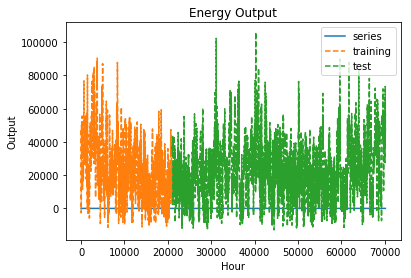

In [485]:
# shift train predictions for plotting
look_back =1
trainPredictPlot = np.empty_like(Cscaled)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, 2] = trainPredict
print(trainPredictPlot.shape)
# shift test predictions for plotting
testPredictPlot = np.empty_like(Cscaled)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back)-2:len(Cscaled)-1, 2] = testPredict
print(testPredictPlot.shape)
#plot

series,=plt.plot(scaler.inverse_transform(Cscaled)[:,2])
prediction_training,=plt.plot(trainPredictPlot[:,2],linestyle='--')
prediction_test,=plt.plot(testPredictPlot[:,2],linestyle='--')
plt.title('Energy Output')
plt.ylabel('Output')
plt.xlabel('Hour')
plt.legend([series,prediction_training,prediction_test],['series','training','test'], loc='upper right')
plt.show()

In [239]:
# import pandas as pd

# def exp(repeats, series, epochs):
#     error_scores = list()
#     for r in range(repeats):
#         # fit the model
#         history = model.fit(train_X, train_y, epochs=epochs,validation_data=(test_X, test_y), batch_size=500, shuffle=True)
#         model.predict(train_X)
#         output = model.predict(test_X)
#         predictions = list()
#         for i in range(len(output)):
#             yhat = output[i,0]
#             X = test[i, 0:-1]
#             # invert scaling
#             yhat = testPredict
#             predictions.append(yhat)
#         # report performance
#         rmse = math.sqrt(mean_squared_error(test_y, testPredict))
#         print('%d) Test RMSE: %.2f' % (r+1, rmse))
#         error_scores.append(rmse)
#         return error_scores
# # experiment
# repeats = 10
# results = pd.DataFrame()
# # vary training epochs
# epochs = [1, 2, 3, 4, 5]
# for e in epochs:
#     results[str(e)] = exp(repeats, series, e)
# # summarize results
# print(results.describe())
# # save boxplot
# results.boxplot()